# Monte Carlo simulator
By: Magnus Kvåle Helliesen

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from monte_carlo import MonteCarlo

## Mathematical background

Suppose we have a matrix of data
$$
    \boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1}),
$$
where
$$
    \boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}
$$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting (empirical) distributions, in order to perform a MonteCarlo-like simulation of the input data.

The idea is to make use of the fact that
$$
    \frac{1}{T}(\boldsymbol{X}-\bar{\boldsymbol{X}})'(\boldsymbol{X}-\bar{\boldsymbol{X}})
    =\frac{1}{T}\boldsymbol{\varepsilon}'\boldsymbol{\varepsilon}
    =\boldsymbol{\Sigma}
    =\boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1}.
$$
That is, the covariance matrix $\boldsymbol{\Sigma}$ can be decomposed into a product of it's eigenvectors $\boldsymbol{Q}$ and eigenvalues $\boldsymbol{\Lambda}$. If we calculate $\boldsymbol{Q}$ and $\boldsymbol{\Lambda}$, then we can construct
$$
    \boldsymbol{\eta}=\boldsymbol{\varepsilon}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2},
$$
which has the property that
$$
    \frac{1}{T}\boldsymbol{\eta}'\boldsymbol{\eta}
    =\boldsymbol{\Lambda}^{-1/2}\boldsymbol{Q}^{-1}\frac{1}{T}\boldsymbol{\varepsilon}'\boldsymbol{\varepsilon}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2}
    =\boldsymbol{\Lambda}^{-1/2}\boldsymbol{Q}^{-1}\boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2}
    =\boldsymbol{I}.
$$
In other words, $\boldsymbol{\eta}$ are orthogonal disturbances. Therefore, we can make $S$ simulations of $\boldsymbol{\eta}$, let's call them
$\hat{\boldsymbol{\eta}}$ and construct simulations of $\boldsymbol{X}$, let's call them $\hat{\boldsymbol{X}}$, using
$$
    \hat{\boldsymbol{X}}
    =\underbrace{\hat{\boldsymbol{\eta}}\boldsymbol{\Lambda}^{1/2}\boldsymbol{Q}^{-1}}_{\equiv\hat{\boldsymbol{\varepsilon}}}+\bar{\boldsymbol{X}}.
$$
What's neat (and also the point) is that
$$
    \frac{1}{S}\hat{\boldsymbol{\varepsilon}}'\hat{\boldsymbol{\varepsilon}}
    =\boldsymbol{Q}\boldsymbol{\Lambda}^{1/2}\frac{1}{S}\hat{\boldsymbol{\eta}}'\hat{\boldsymbol{\eta}}\boldsymbol{\Lambda}^{1/2}\boldsymbol{Q}^{-1}
    \simeq \boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1}
    =\boldsymbol{\Sigma},
$$
because $\frac{1}{S}\hat{\boldsymbol{\eta}}'\hat{\boldsymbol{\eta}}\simeq \boldsymbol{I}$. That is, the simulations preserve the covariance structure.

The whole shabang is done below (including removing heteroskedasticity from $\boldsymbol{\eta}$ using a GARCH-model). The implementation of the Monte Carlo stuff is put in [`monte_carlo.py`](monte_carlo/monte_carlo.py).

# Use MonteCarlo class

In [15]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'KOG.OL', 'TEL.OL', 'FRO.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-24 00:00:00+01:00,17.065422,685.619812,12.610483,10.211597,17.696117,20.904720
2004-03-25 00:00:00+01:00,16.949064,678.345581,12.489224,9.993848,17.996054,21.757975
2004-03-26 00:00:00+01:00,17.104206,680.164307,12.489224,10.005307,18.258490,22.184601
2004-03-29 00:00:00+02:00,17.142986,712.899231,12.731735,9.948001,18.708389,21.651316
2004-03-30 00:00:00+02:00,17.065422,711.080750,12.428596,9.867777,17.696117,21.331341
...,...,...,...,...,...,...
2025-02-24 00:00:00+01:00,254.300003,179.000000,1325.000000,66.779999,142.500000,324.000000
2025-02-25 00:00:00+01:00,254.100006,179.000000,1348.000000,66.620003,145.100006,327.299988
2025-02-26 00:00:00+01:00,258.700012,179.100006,1367.000000,67.540001,145.300003,329.700012


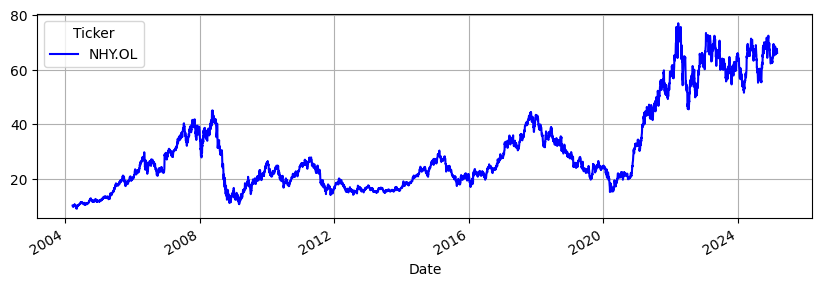

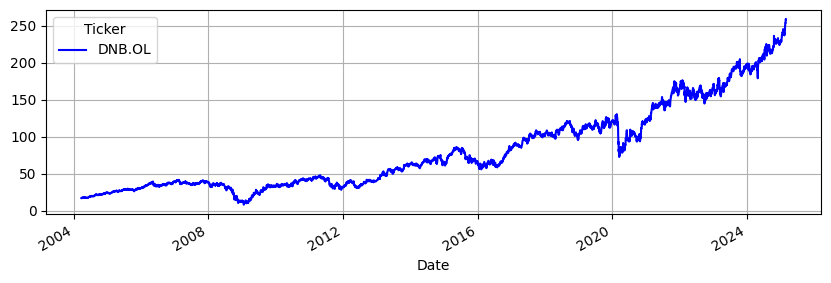

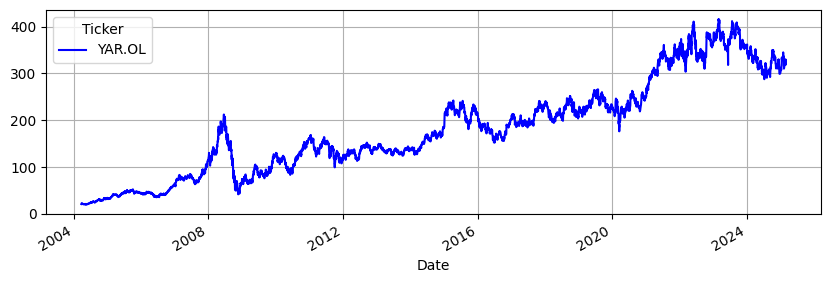

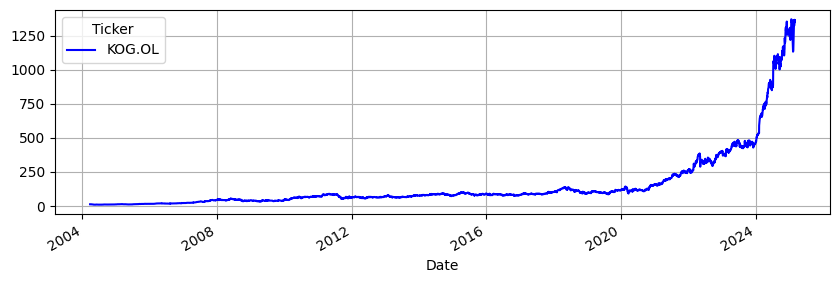

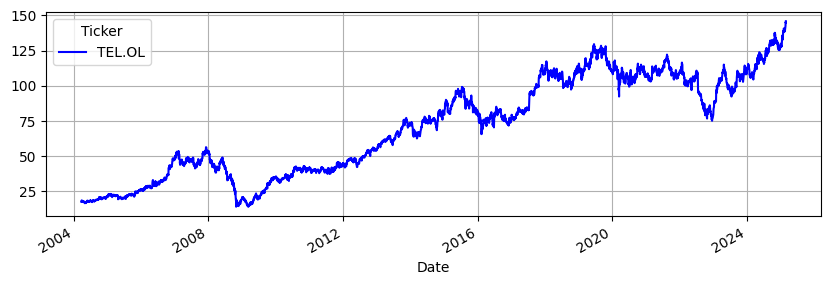

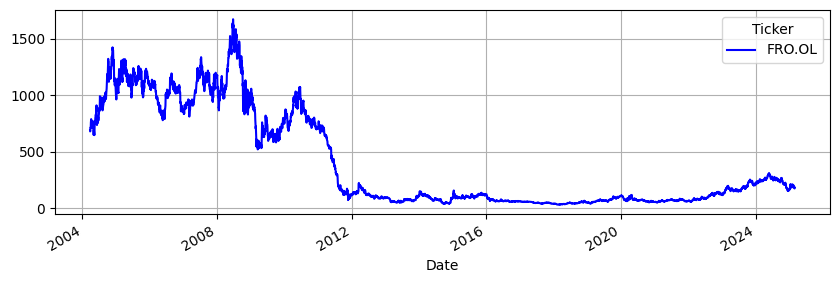

In [16]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [17]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,-0.006842,-0.010666,-0.009662,-0.021554,0.016807,0.040005
2004-03-26 00:00:00+01:00,0.009112,0.002678,0.000000,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.019231,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,-0.024098,-0.008097,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.002561,0.000000,0.003478,0.008439,-0.004008
...,...,...,...,...,...,...
2025-02-24 00:00:00+01:00,0.006707,-0.039972,-0.009016,0.005104,0.009165,0.010861
2025-02-25 00:00:00+01:00,-0.000787,0.000000,0.017210,-0.002399,0.018081,0.010134
2025-02-26 00:00:00+01:00,0.017941,0.000559,0.013997,0.013715,0.001377,0.007306


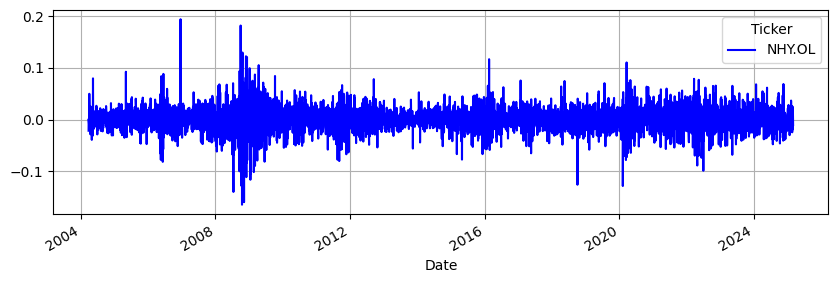

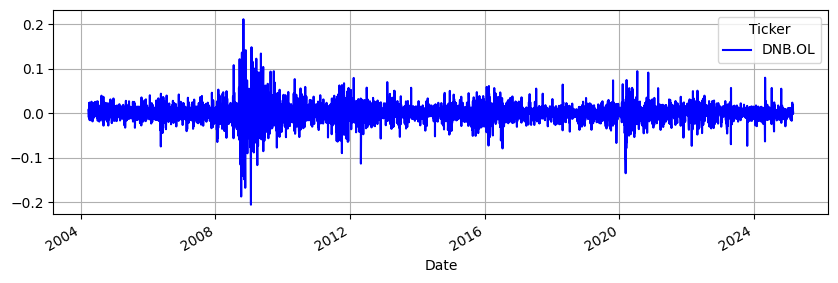

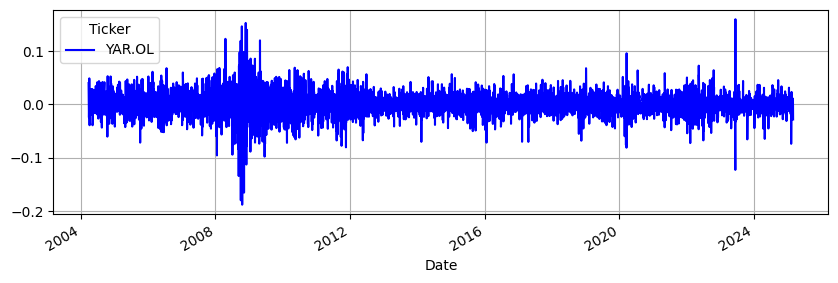

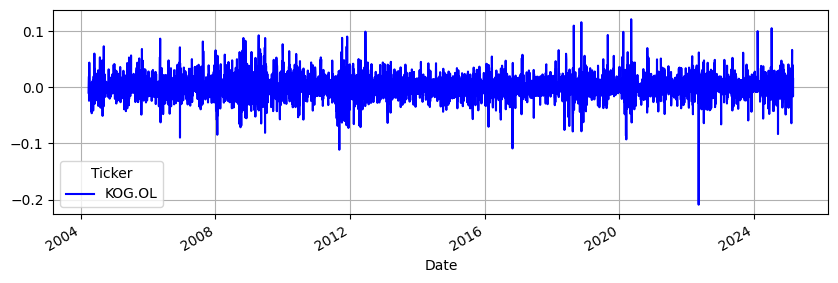

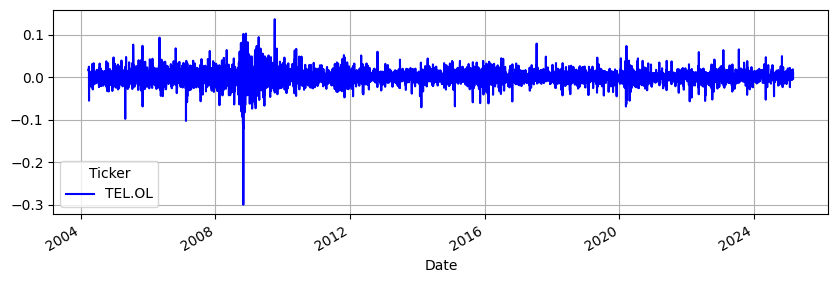

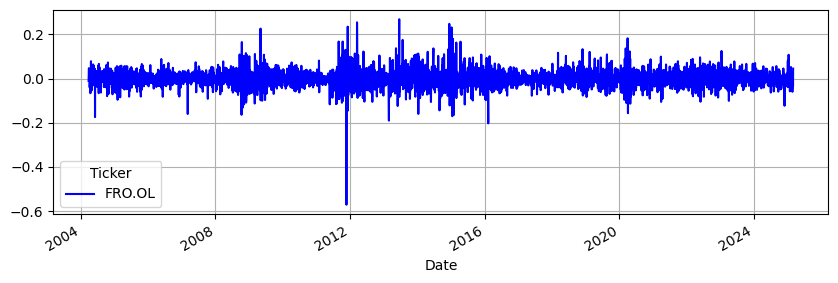

In [18]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [19]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.252641,0.255079,0.470979,0.381991,0.413399
FRO.OL,0.252641,1.000000,0.147745,0.316823,0.195766,0.273259
KOG.OL,0.255079,0.147745,1.000000,0.233346,0.196094,0.199287
NHY.OL,0.470979,0.316823,0.233346,1.000000,0.338968,0.480886
TEL.OL,0.381991,0.195766,0.196094,0.338968,1.000000,0.340905
YAR.OL,0.413399,0.273259,0.199287,0.480886,0.340905,1.000000


In [20]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2,-0.000000,0.000000,1.000000,0.000000,-0.000000,-0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000000
4,0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000
5,0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000


In [21]:
# The normalized ones are nearly orthogonal too
fit.norm_orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999906,-0.068631,0.021331,-0.003866,0.058849,0.002658
1,-0.068631,1.000184,0.011913,-0.001851,0.072689,-0.018352
2,0.021331,0.011913,1.000738,0.000979,-0.027742,0.018988
3,-0.003866,-0.001851,0.000979,1.000185,-0.029898,0.032713
4,0.058849,0.072689,-0.027742,-0.029898,1.000449,0.052862
5,0.002658,-0.018352,0.018988,0.032713,0.052862,1.000121


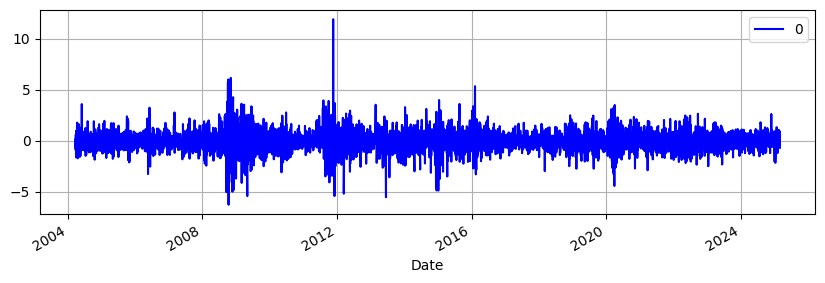

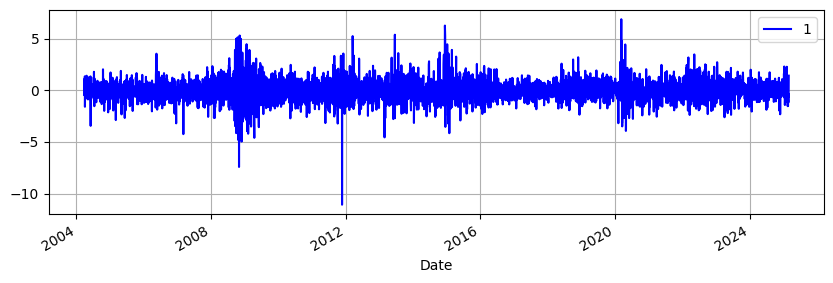

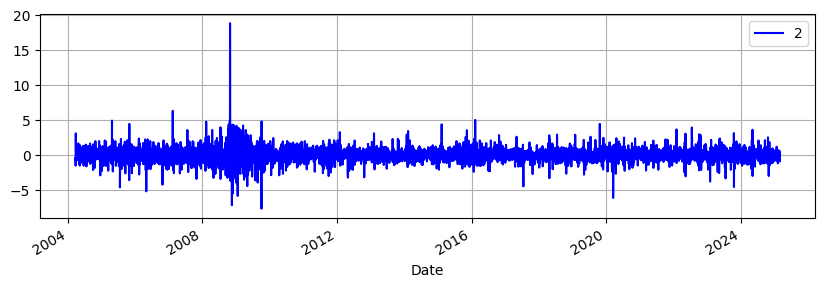

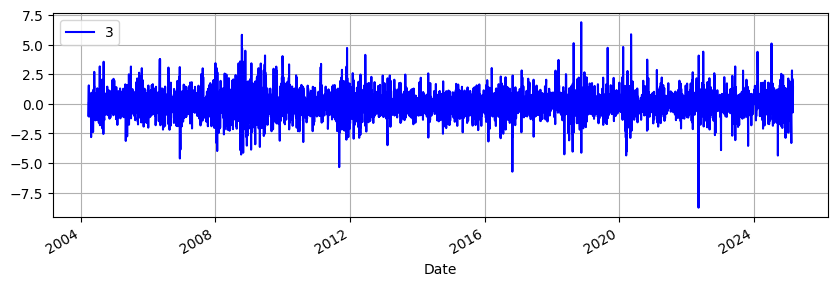

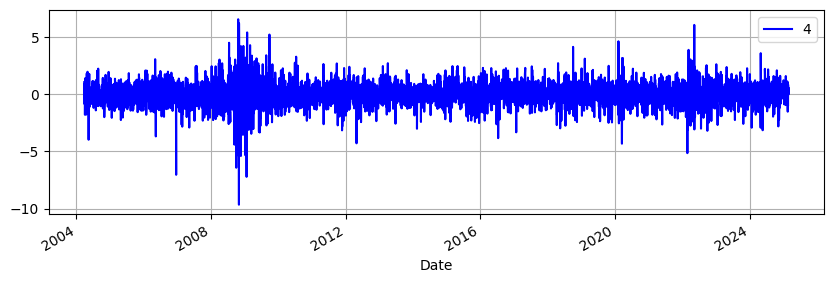

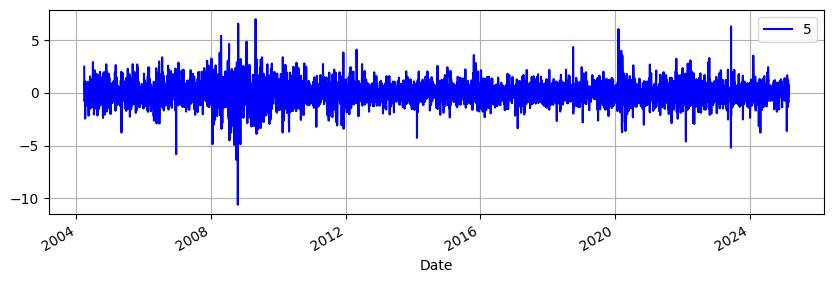

In [22]:
# Orthogonal disturbances
for col in fit.orthog_disturbances_df.columns:
    fit.orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

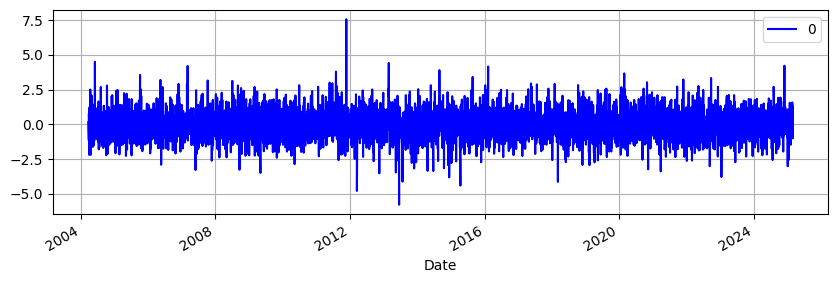

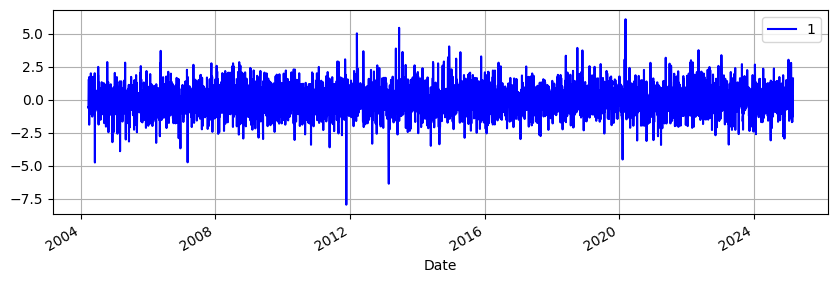

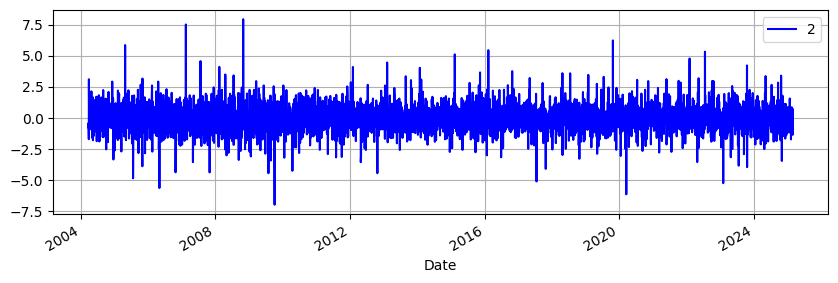

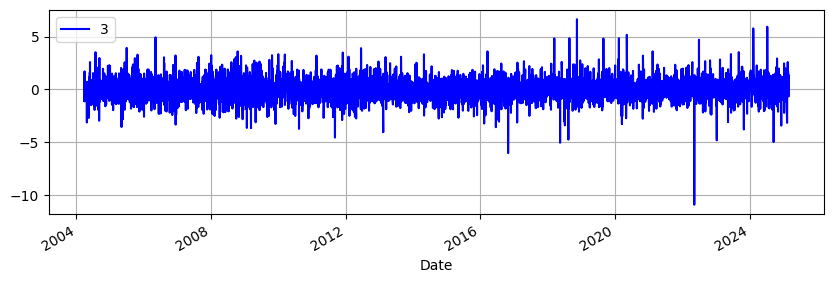

In [ ]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for col in fit.orthog_disturbances_df.columns:
    fit.norm_orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

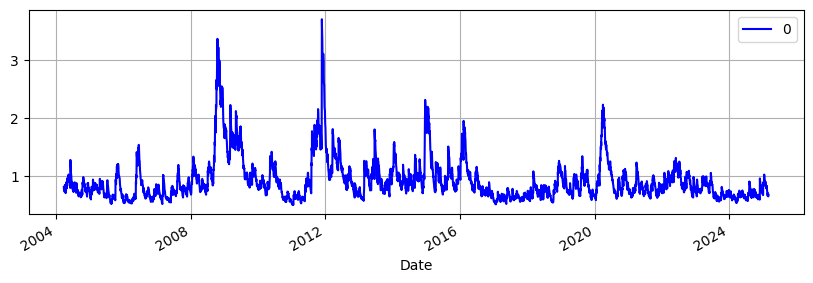

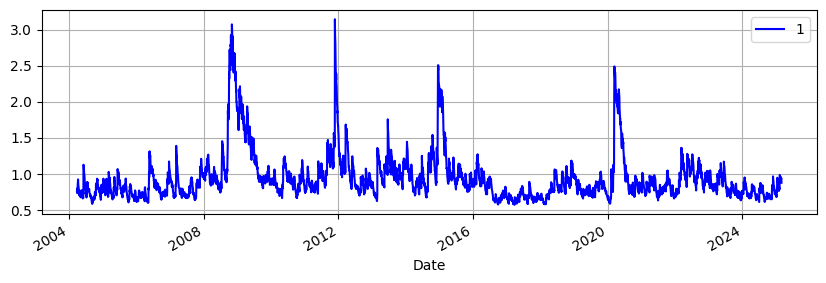

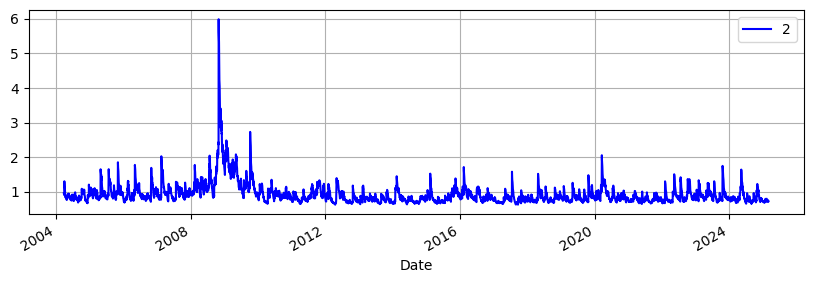

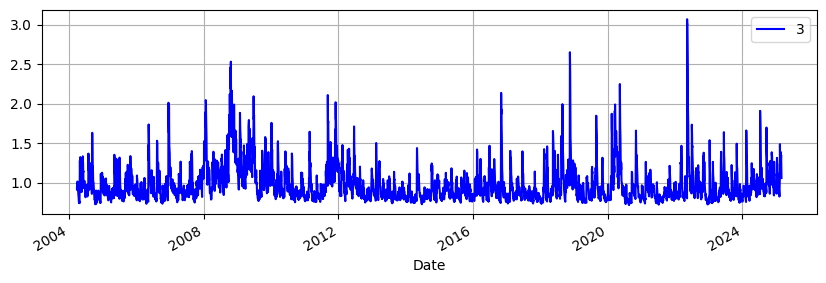

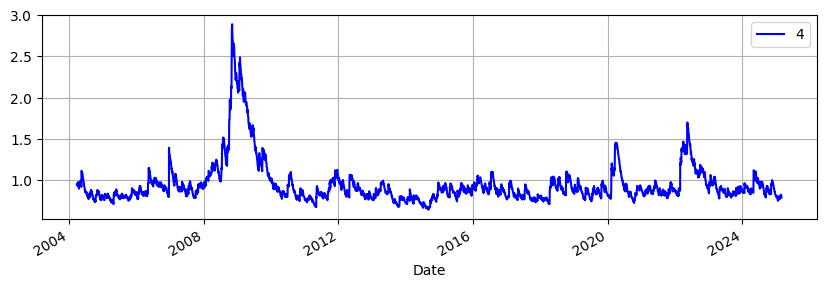

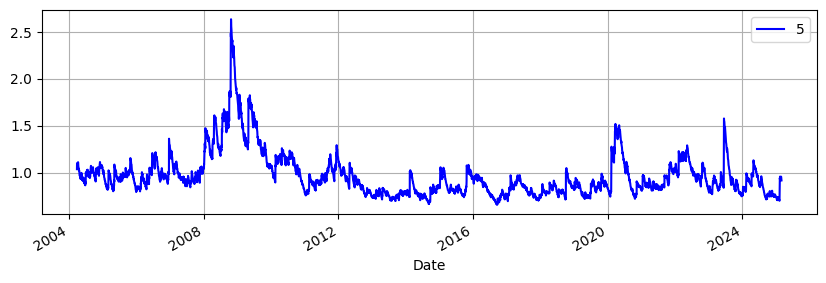

In [ ]:
# Look at GARCH-estimated volatility
for col in fit.conditional_volatility_df.columns:
    fit.conditional_volatility_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

In [12]:
n_periods = 365
n_simulations = 500

# Store forecast in dict
forecast = fit.simulate(n_periods, n_simulations)

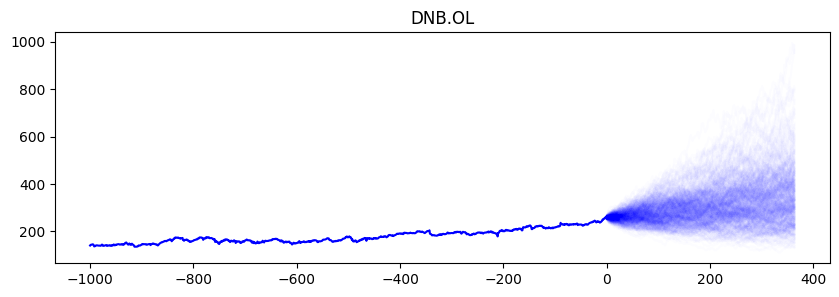

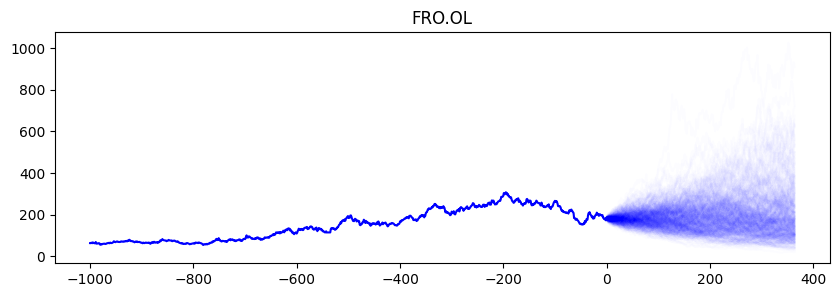

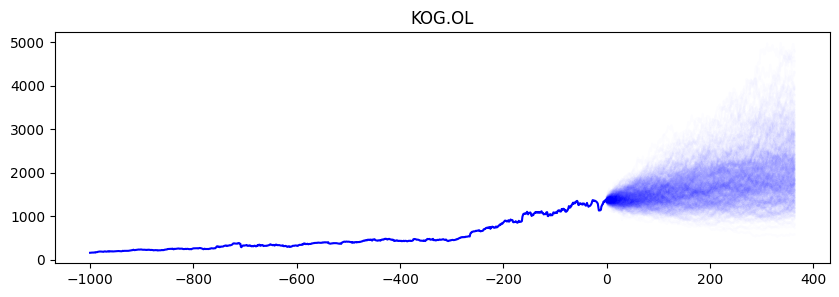

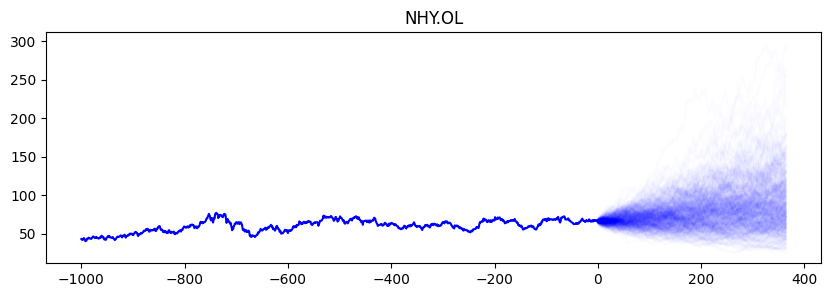

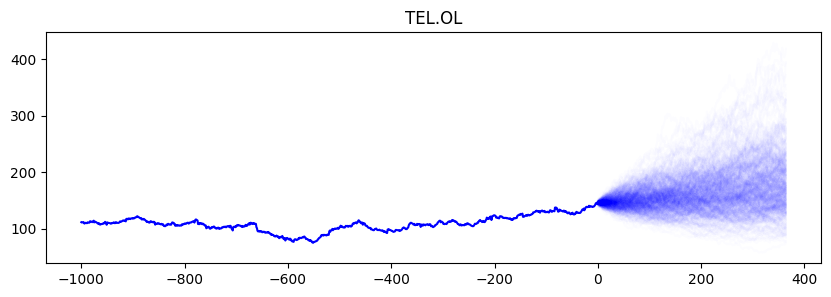

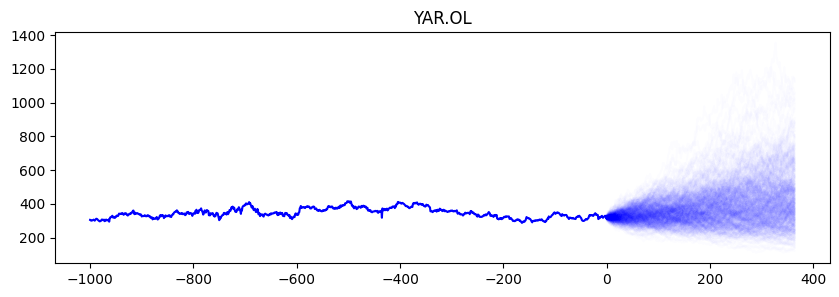

In [ ]:
# Make a new df with index that runs to -1 to allow for plot of simulation from 0
df_range_index = df
df_range_index.index = range(-df_range_index.shape[0], 0)

# Look at some forecast around 0
for col in df.columns:
    plt.figure()
    for i in range(n_simulations):
        (df[col].iloc[-1]*np.exp(forecast.get(i)[col].cumsum())).plot(
            color = 'b', alpha=5/n_simulations, figsize=(10, 3), grid=True, title=col
            )
    df_range_index.loc[-1000:, col].plot(color = 'b')
    plt.show()